In [2]:
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

! ls

In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt



from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


... done downloading pretrained model!


In [4]:
from config import Config

class BowlConfig(Config): 
    NAME = "nucleos" 
    GPU_COUNT = 1 
    IMAGES_PER_GPU = 1 
    NUM_CLASSES = 1 + 1 
    IMAGE_MIN_DIM = 256 
    IMAGE_MAX_DIM = 512 
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64) 
    TRAIN_ROIS_PER_IMAGE = 500 
    STEPS_PER_EPOCH = 600 # (IMAGES_PER_GPU * GPU_COUNT) 
    VALIDATION_STEPS = 70 # (IMAGES_PER_GPU * GPU_COUNT) 
    MEAN_PIXEL = [0, 0, 0] 
    LEARNING_RATE = 0.01 
    USE_MINI_MASK = True 
MAX_GT_INSTANCES = 500
config = BowlConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [0, 0, 0]
MINI_MASK_SHAPE                (56, 56)
NAME                           nucleos
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [7]:
class NucleiDataset(utils.Dataset):
    """Override:
            load_image()
            load_mask()
            image_reference()
    """

    def add_nuclei(self, root_dir, mode, split_ratio=0.9):
        # Add classes
        self.add_class("nuclei", 1, "nuclei") # source, id, name. id = 0s is BG

        image_names = os.listdir(root_dir)
        length = len(image_names)
        
        np.random.seed(1000)
        image_names = list(np.random.permutation(image_names))
        np.random.seed(None)
        
        if mode == 'train':
            image_names = image_names[: int(split_ratio*length)]
        if mode == 'val':
            image_names = image_names[int(split_ratio*length):]
        if mode == 'val_as_test':
            image_names = image_names[int(split_ratio*length):]     
            mode = 'test'
        dirs = [root_dir + img_name + '/images/' for img_name in image_names]
        mask_dirs = [root_dir + img_name + '/masks/' for img_name in image_names]

        # Add images
        for i in range(len(image_names)):
            self.add_image(
                source = "nuclei", 
                image_id = i,
                path = dirs[i] + image_names[i] + '.png',
                mask_dir = mask_dirs[i],
                name = image_names[i]
                )
      

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        image = imageio.imread(self.image_info[image_id]['path'])
        # RGBA to RGB
        if image.shape[2] != 3:
            image = image[:,:,:3]
        return image
    
    def image_reference(self, image_id):
        """Return the details of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nuclei":
            return info["path"]
        else:
            super(NucleiDataset, self).image_reference(self, image_id)

    def load_mask(self, image_id):
        """ 
        Returns:
            masks: A binary array of shape [height, width, instance count] with
                a binary mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        mask_dir= info['mask_dir'] 
        mask_names = os.listdir(mask_dir)
        mask_paths = [mask_dir + mask_name for mask_name in mask_names]
        
        count = len(mask_paths)
        
        masks = [imageio.imread(path) for path in mask_paths]
        mask = np.stack(masks, axis=-1)
#        mask = mask.astype(bool)
        mask = np.where(mask>128, 1, 0)
        
        class_ids = np.ones(count,dtype=np.int32)
        return mask, class_ids
    
    def load_semantic(self, image_id):
        info = self.image_info[image_id]
        path = info['mask_dir'].replace('masks','images') 
        mask_path = path + 'mask.png'
        
        
        mask = imageio.imread(mask_path)
        mask = np.where(mask>128, 1, 0)
        return mask


In [19]:

import utils
import numpy as np
import imageio
import os

dataset_train = NucleiDataset()
dataset_val = NucleiDataset()
dataset_val.add_nuclei('stage1_train/','val')
dataset_train.add_nuclei('stage1_train/','train')
dataset_train.prepare()
dataset_val.prepare()

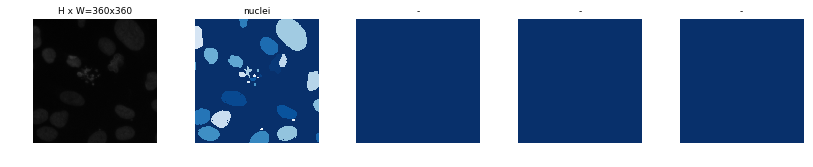

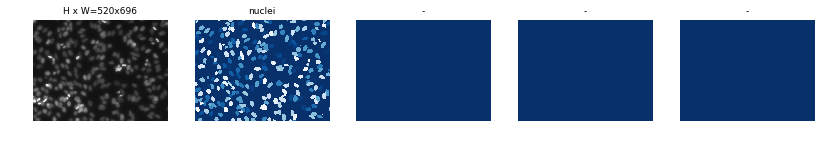

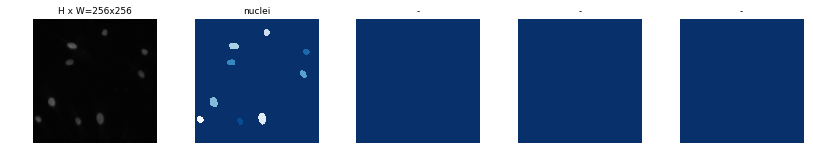

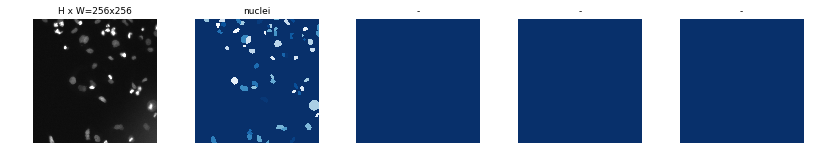

In [23]:
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


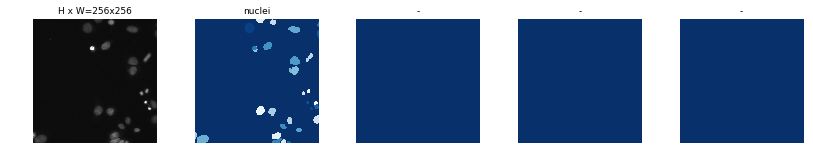

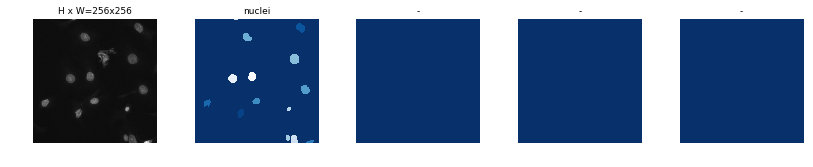

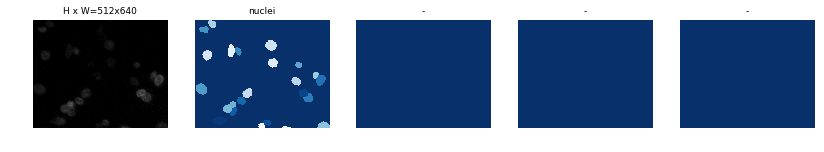

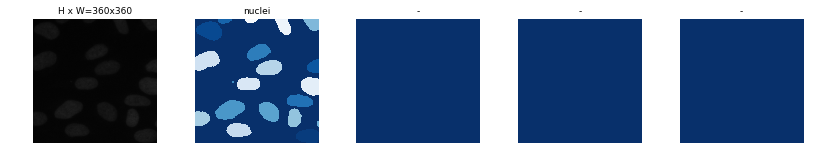

In [24]:
image_ids = np.random.choice(dataset_val.image_ids, 4)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)


In [20]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


In [21]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [28]:
model.keras_model.layers

In [22]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.01

Checkpoint Path: /Users/piyushgandhi811/Desktop/Competitions/Data_Science_Bowl_Kaggle/Mask_RCNN/logs/nucleos20180406T1646/mask_rcnn_nucleos_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistri

/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  1/600 [..............................] - ETA: 7:12:26 - loss: 6.2038 - rpn_class_loss: 0.4474 - rpn_bbox_loss: 1.8087 - mrcnn_class_loss: 0.6033 - mrcnn_bbox_loss: 2.4127 - mrcnn_mask_loss: 0.9316

Process Process-3:
Traceback (most recent call last):
  File "/Users/piyushgandhi811/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/piyushgandhi811/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "/Users/piyushgandhi811/Desktop/Competitions/Data_Science_Bowl_Kaggle/Mask_RCNN/model.py", line 1647, in data_generator
    gt_class_ids, gt_boxes, config)
  File "/Users/piyushgandhi811/Desktop/Competitions/Data_Science_Bowl_Kaggle/Mask_RCNN/model.py", line 1445, in build_rpn_targets
    gt_iou_argmax = np.argmax(overlaps, axis=0)
  File "/Users/piyushgandhi811/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 1004, in argmax
    return _wrapfunc(a, 'argmax', axis=axi

KeyboardInterrupt: 